In [1]:
import pandas as pd

In [2]:
radar_data = pd.read_csv('outputRadar2.csv')
camera_data = pd.read_csv('outputCamera1.csv')

In [31]:
merged_data= pd.concat([radar_data, camera_data], axis=1)
merged_data.head()

,time,range_radar,velocity_radar,AoA_radar,time,range_camera,velocity_camera,AoA_camera
0,0.0,378.929664,13.561884,-2.672516,0.0,378.929664,13.561884,-2.672516
1,0.0,248.211704,18.178031,-2.669837,0.0,248.211704,18.178031,-2.669837
2,0.0,212.676491,16.456920,-2.652078,0.0,212.676491,16.456920,-2.652078
3,0.0,122.375529,6.621422,0.179927,0.0,122.375529,6.621422,0.179927
4,0.0,319.027840,19.032024,-2.645719,0.0,319.027840,19.032024,-2.645719


In [6]:
threshold=0.1

In [7]:
merged_data['contradiction'] = (abs(merged_data[' velocity_radar'] - merged_data[' velocity_camera']) > threshold) | (abs(merged_data[' AoA_radar'] - merged_data[' AoA_camera']) > threshold) | (abs(merged_data[' range_radar'] - merged_data[' range_camera']) > threshold)


In [24]:
X = merged_data[[' velocity_radar', ' AoA_radar', ' range_radar', ' velocity_camera', ' AoA_camera', ' range_camera']]
y = merged_data['contradiction']

In [25]:
for i in y: 
    if (i == True):
     print("Switch to manual mode!")
     break

Switch to manual mode!


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
 

def create_siamese_model(input_shape):
    # Define the left and right input layers
    radar_input = Input(input_shape, name='radar_input')
    camera_input = Input(input_shape, name='camera_input')

    # Shared convolutional layers
    conv_net = tf.keras.Sequential()
    conv_net.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    conv_net.add(Conv2D(64, (3,3), activation='relu'))
    conv_net.add(Conv2D(64, (3,3), activation='relu'))
    conv_net.add(Flatten())

    # Generate the encodings for the radar and camera inputs
    radar_encoding = conv_net(radar_input)
    camera_encoding = conv_net(camera_input)

    # Concatenate the encodings
    concatenated = tf.keras.layers.concatenate([radar_encoding, camera_encoding])

    # Add a fully connected layer
    fc = Dense(128, activation='relu')(concatenated)

    # Add the output layer
    output = Dense(1, activation='sigmoid')(fc)

    # Create the Siamese model
    siamese_model = Model(inputs=[radar_input, camera_input], outputs=output)

    return siamese_model

# Example usage
input_shape = (64, 64, 3)  # Adjust input shape according to your data
siamese_model = create_siamese_model(input_shape)
siamese_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 radar_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 camera_input (InputLayer)      [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 215296)       56320       ['radar_input[0][0]',            
                                                                  'camera_input[0][0]']           
                                                                                                  
 concatenate (Concatenate)      (None, 430592)       0           ['sequential[0][0]',         

In [ ]:
siamese_model = create_siamese_model(input_shape)

# Compile the model
siamese_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

# Train the model
siamese_model.fit([radar_train, camera_train], labels_train,
                  validation_data=([radar_val, camera_val], labels_val),
                  epochs=10, batch_size=32)

In [37]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and preprocess your CSV data
radar_data = pd.read_csv('outputRadar2.csv')
camera_data = pd.read_csv('outputCamera1.csv')

# Assuming radar_data and camera_data have the same number of samples
num_samples = radar_data.shape[0]

# Split the data into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(num_samples * train_ratio)

radar_train = radar_data[:train_size]
radar_val = radar_data[train_size:]

camera_train = camera_data[:train_size]
camera_val = camera_data[train_size:]

# Define the input shapes
input_dim = radar_data.shape[1]  # Assuming radar_data and camera_data have the same number of features

def create_siamese_model(input_dim):
    # Model architecture
    radar_input = Input(shape=(input_dim,), name='radar_input')
    camera_input = Input(shape=(input_dim,), name='camera_input')

    # Shared layers
    shared_layers = [
        Dense(64, activation='relu'),
        Dense(32, activation='relu')
    ]

    # Apply shared layers to each input
    radar_hidden = radar_input
    camera_hidden = camera_input
    for layer in shared_layers:
        radar_hidden = layer(radar_hidden)
        camera_hidden = layer(camera_hidden)

    # Concatenate the outputs of shared layers
    concatenated = Concatenate()([radar_hidden, camera_hidden])

    # Add dense layers for further processing
    fc = Dense(16, activation='relu')(concatenated)

    # Output layer
    output = Dense(1, activation='sigmoid')(fc)

    # Create the Siamese model
    siamese_model = Model(inputs=[radar_input, camera_input], outputs=output)

    return siamese_model

# Create the Siamese model
siamese_model = create_siamese_model(input_dim)

# Define the contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return tf.reduce_mean((1 - y_true) * tf.square(y_pred) + y_true * tf.square(tf.maximum(margin - y_pred, 0)))

# Compile the model
siamese_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss=contrastive_loss,
                      metrics=['accuracy'])

# Train the model
siamese_model.fit([radar_train, camera_train], np.ones((train_size,)),
                  validation_data=([radar_val, camera_val], np.ones((num_samples - train_size,))),
                  epochs=10, batch_size=32)


Epoch 1/10
76/76 [==============================] - 1s 6ms/step - loss: 5.7373e-07 - accuracy: 1.0000 - val_loss: 1.5759e-11 - val_accuracy: 1.0000
Epoch 2/10
76/76 [==============================] - 0s 2ms/step - loss: 3.5660e-11 - accuracy: 1.0000 - val_loss: 1.5391e-11 - val_accuracy: 1.0000
Epoch 3/10
76/76 [==============================] - 0s 2ms/step - loss: 3.5159e-11 - accuracy: 1.0000 - val_loss: 1.5142e-11 - val_accuracy: 1.0000
Epoch 4/10
76/76 [==============================] - 0s 2ms/step - loss: 3.4590e-11 - accuracy: 1.0000 - val_loss: 1.4866e-11 - val_accuracy: 1.0000
Epoch 5/10
76/76 [==============================] - 0s 2ms/step - loss: 3.3943e-11 - accuracy: 1.0000 - val_loss: 1.4555e-11 - val_accuracy: 1.0000
Epoch 6/10
76/76 [==============================] - 0s 2ms/step - loss: 3.3249e-11 - accuracy: 1.0000 - val_loss: 1.4259e-11 - val_accuracy: 1.0000
Epoch 7/10
76/76 [==============================] - 0s 2ms/step - loss: 3.2542e-11 - accuracy: 1.0000 - val_loss

In [43]:
# Set similarity threshold
threshold = 0.1

# Predict on the validation data
predictions = siamese_model.predict([radar_val, camera_val])

# Identify potential contradictions based on the threshold
potential_contrdictions = np.where(predictions > threshold)[0]
print('Number of potential contradictions:', len(potential_contrdictions))



19/19 [==============================] - 0s 850us/step
Number of potential contradictions: 601


In [40]:
# Reconstruct the radar and camera inputs
reconstructed_radar = siamese_model.predict([radar_data, camera_data])
reconstructed_camera = siamese_model.predict([radar_data, camera_data])

# Calculate the reconstruction errors
radar_reconstruction_error = np.mean(np.square(radar_data - reconstructed_radar), axis=1)
camera_reconstruction_error = np.mean(np.square(camera_data - reconstructed_camera), axis=1)

# Compute an overall reconstruction error by averaging the errors from both inputs
overall_reconstruction_error = (radar_reconstruction_error + camera_reconstruction_error) / 2

# Sort the examples based on the reconstruction error in descending order
sorted_indices = np.argsort(overall_reconstruction_error)[::-1]


94/94 [==============================] - 0s 830us/step


ValueError: No such layer: fc. Existing layers are: ['radar_input', 'camera_input', 'dense_10', 'dense_11', 'concatenate_3', 'dense_12', 'dense_13'].

In [44]:
import pandas as pd

radar_data = pd.read_csv('outputRadar2.csv')
camera_data = pd.read_csv('outputCamera1.csv')

radar_data=radar_data.drop(['time'],axis='columns')
camera_data=camera_data.drop(['time'],axis='columns')

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

radar_data_scaled = scaler.fit_transform(radar_data)
camera_data_scaled = scaler.fit_transform(camera_data)


In [46]:
from sklearn.model_selection import train_test_split

# Split radar_data and camera_data into training and testing sets
radar_train, radar_test, camera_train, camera_test = train_test_split(radar_data_scaled, camera_data_scaled, test_size=0.2, random_state=42)


In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input shapes
input_shape = (radar_data.shape[1],)  # Assuming radar_data and camera_data have the same number of features

def create_siamese_model(input_shape):
    # Model architecture
    radar_input = Input(shape=input_shape, name='radar_input')
    camera_input = Input(shape=input_shape, name='camera_input')

    # Shared layers
    shared_layers = [
        Dense(64, activation='relu'),
        Dense(32, activation='relu')
    ]

    # Apply shared layers to each input
    radar_hidden = radar_input
    camera_hidden = camera_input
    for layer in shared_layers:
        radar_hidden = layer(radar_hidden)
        camera_hidden = layer(camera_hidden)

    # Concatenate the outputs of shared layers
    concatenated = Concatenate()([radar_hidden, camera_hidden])

    # Add dense layers for further processing
    fc = Dense(16, activation='relu')(concatenated)

    # Output layer
    output = Dense(1, activation='sigmoid')(fc)

    # Create the Siamese model
    siamese_model = Model(inputs=[radar_input, camera_input], outputs=output)

    return siamese_model

# Create the Siamese model
siamese_model = create_siamese_model(input_shape)


In [52]:
import numpy as np
from tensorflow.keras.optimizers import Adam

# Create labels for the training data (self-supervised task)
num_samples = radar_train.shape[0]
labels = np.ones(num_samples)  # Assign positive label to all samples

# Concatenate the training data for the Siamese model
x_train = [radar_train, camera_train]

# Compile the model with binary cross-entropy loss
siamese_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# Train the model
siamese_model.fit(x_train, labels, epochs=10, batch_size=32)



Epoch 1/10
76/76 [==============================] - 0s 1ms/step - loss: 0.1618
Epoch 2/10
76/76 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 3/10
76/76 [==============================] - 0s 1ms/step - loss: 4.2352e-04
Epoch 4/10
76/76 [==============================] - 0s 1ms/step - loss: 2.2312e-04
Epoch 5/10
76/76 [==============================] - 0s 1ms/step - loss: 1.3796e-04
Epoch 6/10
76/76 [==============================] - 0s 1ms/step - loss: 9.3091e-05
Epoch 7/10
76/76 [==============================] - 0s 1ms/step - loss: 6.7250e-05
Epoch 8/10
76/76 [==============================] - 0s 1ms/step - loss: 5.0747e-05
Epoch 9/10
76/76 [==============================] - 0s 1ms/step - loss: 3.9618e-05
Epoch 10/10
76/76 [==============================] - 0s 1ms/step - loss: 3.1851e-05


In [53]:
# Reconstruct the radar and camera inputs
reconstructed_radar = siamese_model.predict([radar_data, camera_data])
reconstructed_camera = siamese_model.predict([radar_data, camera_data])

# Calculate the reconstruction errors
radar_reconstruction_error = np.mean(np.square(radar_data - reconstructed_radar), axis=1)
camera_reconstruction_error = np.mean(np.square(camera_data - reconstructed_camera), axis=1)

# Compute an overall reconstruction error by averaging the errors from both inputs
overall_reconstruction_error = (radar_reconstruction_error + camera_reconstruction_error) / 2

# Sort the examples based on the reconstruction error in descending order
sorted_indices = np.argsort(overall_reconstruction_error)[::-1]


94/94 [==============================] - 0s 853us/step


In [54]:
# Obtain embeddings for the entire dataset
embeddings = siamese_model.predict([radar_data, camera_data])

# Apply clustering algorithm (e.g., K-means, DBSCAN, etc.) to cluster the embeddings into groups
# Perform further analysis on the resulting clusters


94/94 [==============================] - 0s 792us/step


C:\Users\sabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


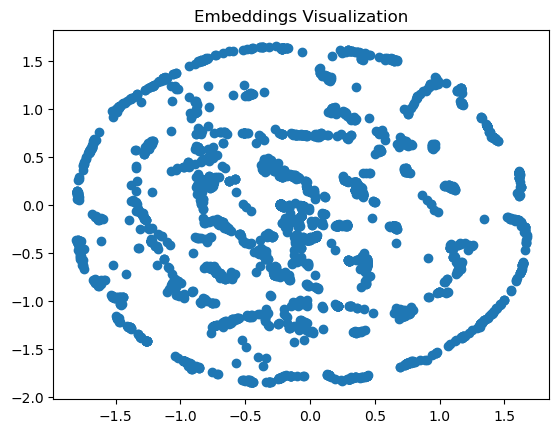

In [55]:
# Use t-SNE or UMAP to reduce the dimensionality of the embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize the embeddings in a scatter plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title('Embeddings Visualization')
plt.show()


In [56]:
# Calcul de la similarité entre les données radar et de caméra
similarity_scores = siamese_model.predict([radar_data, camera_data])

# Afficher les scores de similarité
print(similarity_scores)


94/94 [==============================] - 0s 809us/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [69]:
threshold = 0.1  # Définissez votre seuil ici

# Identifier les contradictions potentielles en fonction du seuil
contradictions = np.where(similarity_scores > threshold)[0]

# Afficher le nombre de contradictions potentielles
print("Nombre de contradictions potentielles :", len(contradictions))


Nombre de contradictions potentielles : 3003
